# Vinho Verde: Wine Quality Analysis

## Introduction

Wine is an alcoholic beverage made from the fermentation of grape juice, with many factors determining its quality. Wine without any acidity is “flat”, hence a fixed acidity level. Volatile acidity is the measure of acetic acid in wine, if it is above a threshold the wine will taste sour, citric acid enhances the flavour, residual sugar in wine is leftover sugar from grapes; higher sugar levels increase sweetness, and chloride contributes to saltiness in wine. 

**The main question we are answering is: What produces the highest quality of wine given our predictors, (VA, citric acidity, residual sugar, chloride, sulfur dioxide, and sulphate)?**

The dataset used is collected by Paulo Cortez, from the University of Minho in Portugal. He, along with A. Cerdeira, F. Almeida, T. Matos, and J. Reis, Viticulture Commission of the Vinho Verde Region(CVRVV), Porto, Portugal collected data about the Vinho Verde wines from Portugal. This dataset (from 2009) observes the physicochemical qualities of the wine (acidity, sulphates, etc.), and excludes grape type, wine brand, or other subjective qualities.

**Citation:**

P. Cortez, A. Cerdeira, F. Almeida, T. Matos, and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009

## Preliminary exploratory data analysis

In [5]:
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)
options(repr.matrix.max.rows = 4)
set.seed(10000)

We use the `read_csv2()` function to read the file from the web.

In [272]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_red <- read_csv2(url)

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (5): volatile acidity, citric acid, chlorides, density, sulphates
dbl (2): total sulfur dioxide, quality

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We clean the column names to remove spaces using `make.names`, then change the datatypes of columns to dbl using `mutate()` and `as.double()`.

In [273]:
colnames(wine_red) <- make.names(colnames(wine_red))

wine_red <- wine_red |>
            mutate(across(everything(), as.double), quality = as.factor(quality))

wine_red

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
74,0.70,0,19,0.076,11,34,0.9978,351,0.56,94,5
78,0.88,0,26,0.098,25,67,0.9968,32,0.68,98,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
59,0.645,0.12,2,0.075,32,44,0.99547,357,0.71,102,5
6,0.310,0.47,36,0.067,18,42,0.99549,339,0.66,11,6


Splitting the dataset into training and testing sets.

In [274]:
set.seed(10)

wine_split <- initial_split(wine_red, prop = 0.75, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

wine_train

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
78,0.88,0.00,26,0.098,25,67,0.9968,32,0.68,98,5
78,0.76,0.04,23,0.092,15,54,0.9970,326,0.65,98,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
7,0.56,0.17,17,0.065,15,24,0.99514,344,0.68,1055,7
67,0.32,0.44,24,0.061,24,34,0.99484,329,0.80,116,7


------

### 1. Checking and removing any NA Values in our data
Checking how many NA values are present in each column using the `apply()` function and removing them using `drop_na()`.

In [291]:
apply(X = is.na(wine_train), MARGIN = 2, FUN = sum)

wine_train <- drop_na(wine_train)
wine_test <- drop_na(wine_test)

citric.acid total.sulfur.dioxide     volatile.acidity 
                   0                    0                    0 
           sulphates              quality 
                   0                    0

In [292]:
apply(X = is.na(wine_train), MARGIN = 2, FUN = sum)

citric.acid total.sulfur.dioxide     volatile.acidity 
                   0                    0                    0 
           sulphates              quality 
                   0                    0

**At this point our data is tidy.**

Data is considered "tidy" when it is organized in a way that makes it easy to work with and perform analysis on. A tidy dataset has the following characteristics:
- Each variable is in a column.
- Each observation is in a row.
- Each value is a cell in the dataset.

### 2. Choosing which predictor variables we wish to keep for our model. 

To choose which predictor variables to keep and which to remove, we can plot a ggpairs plot to see the individual correlations between each column.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



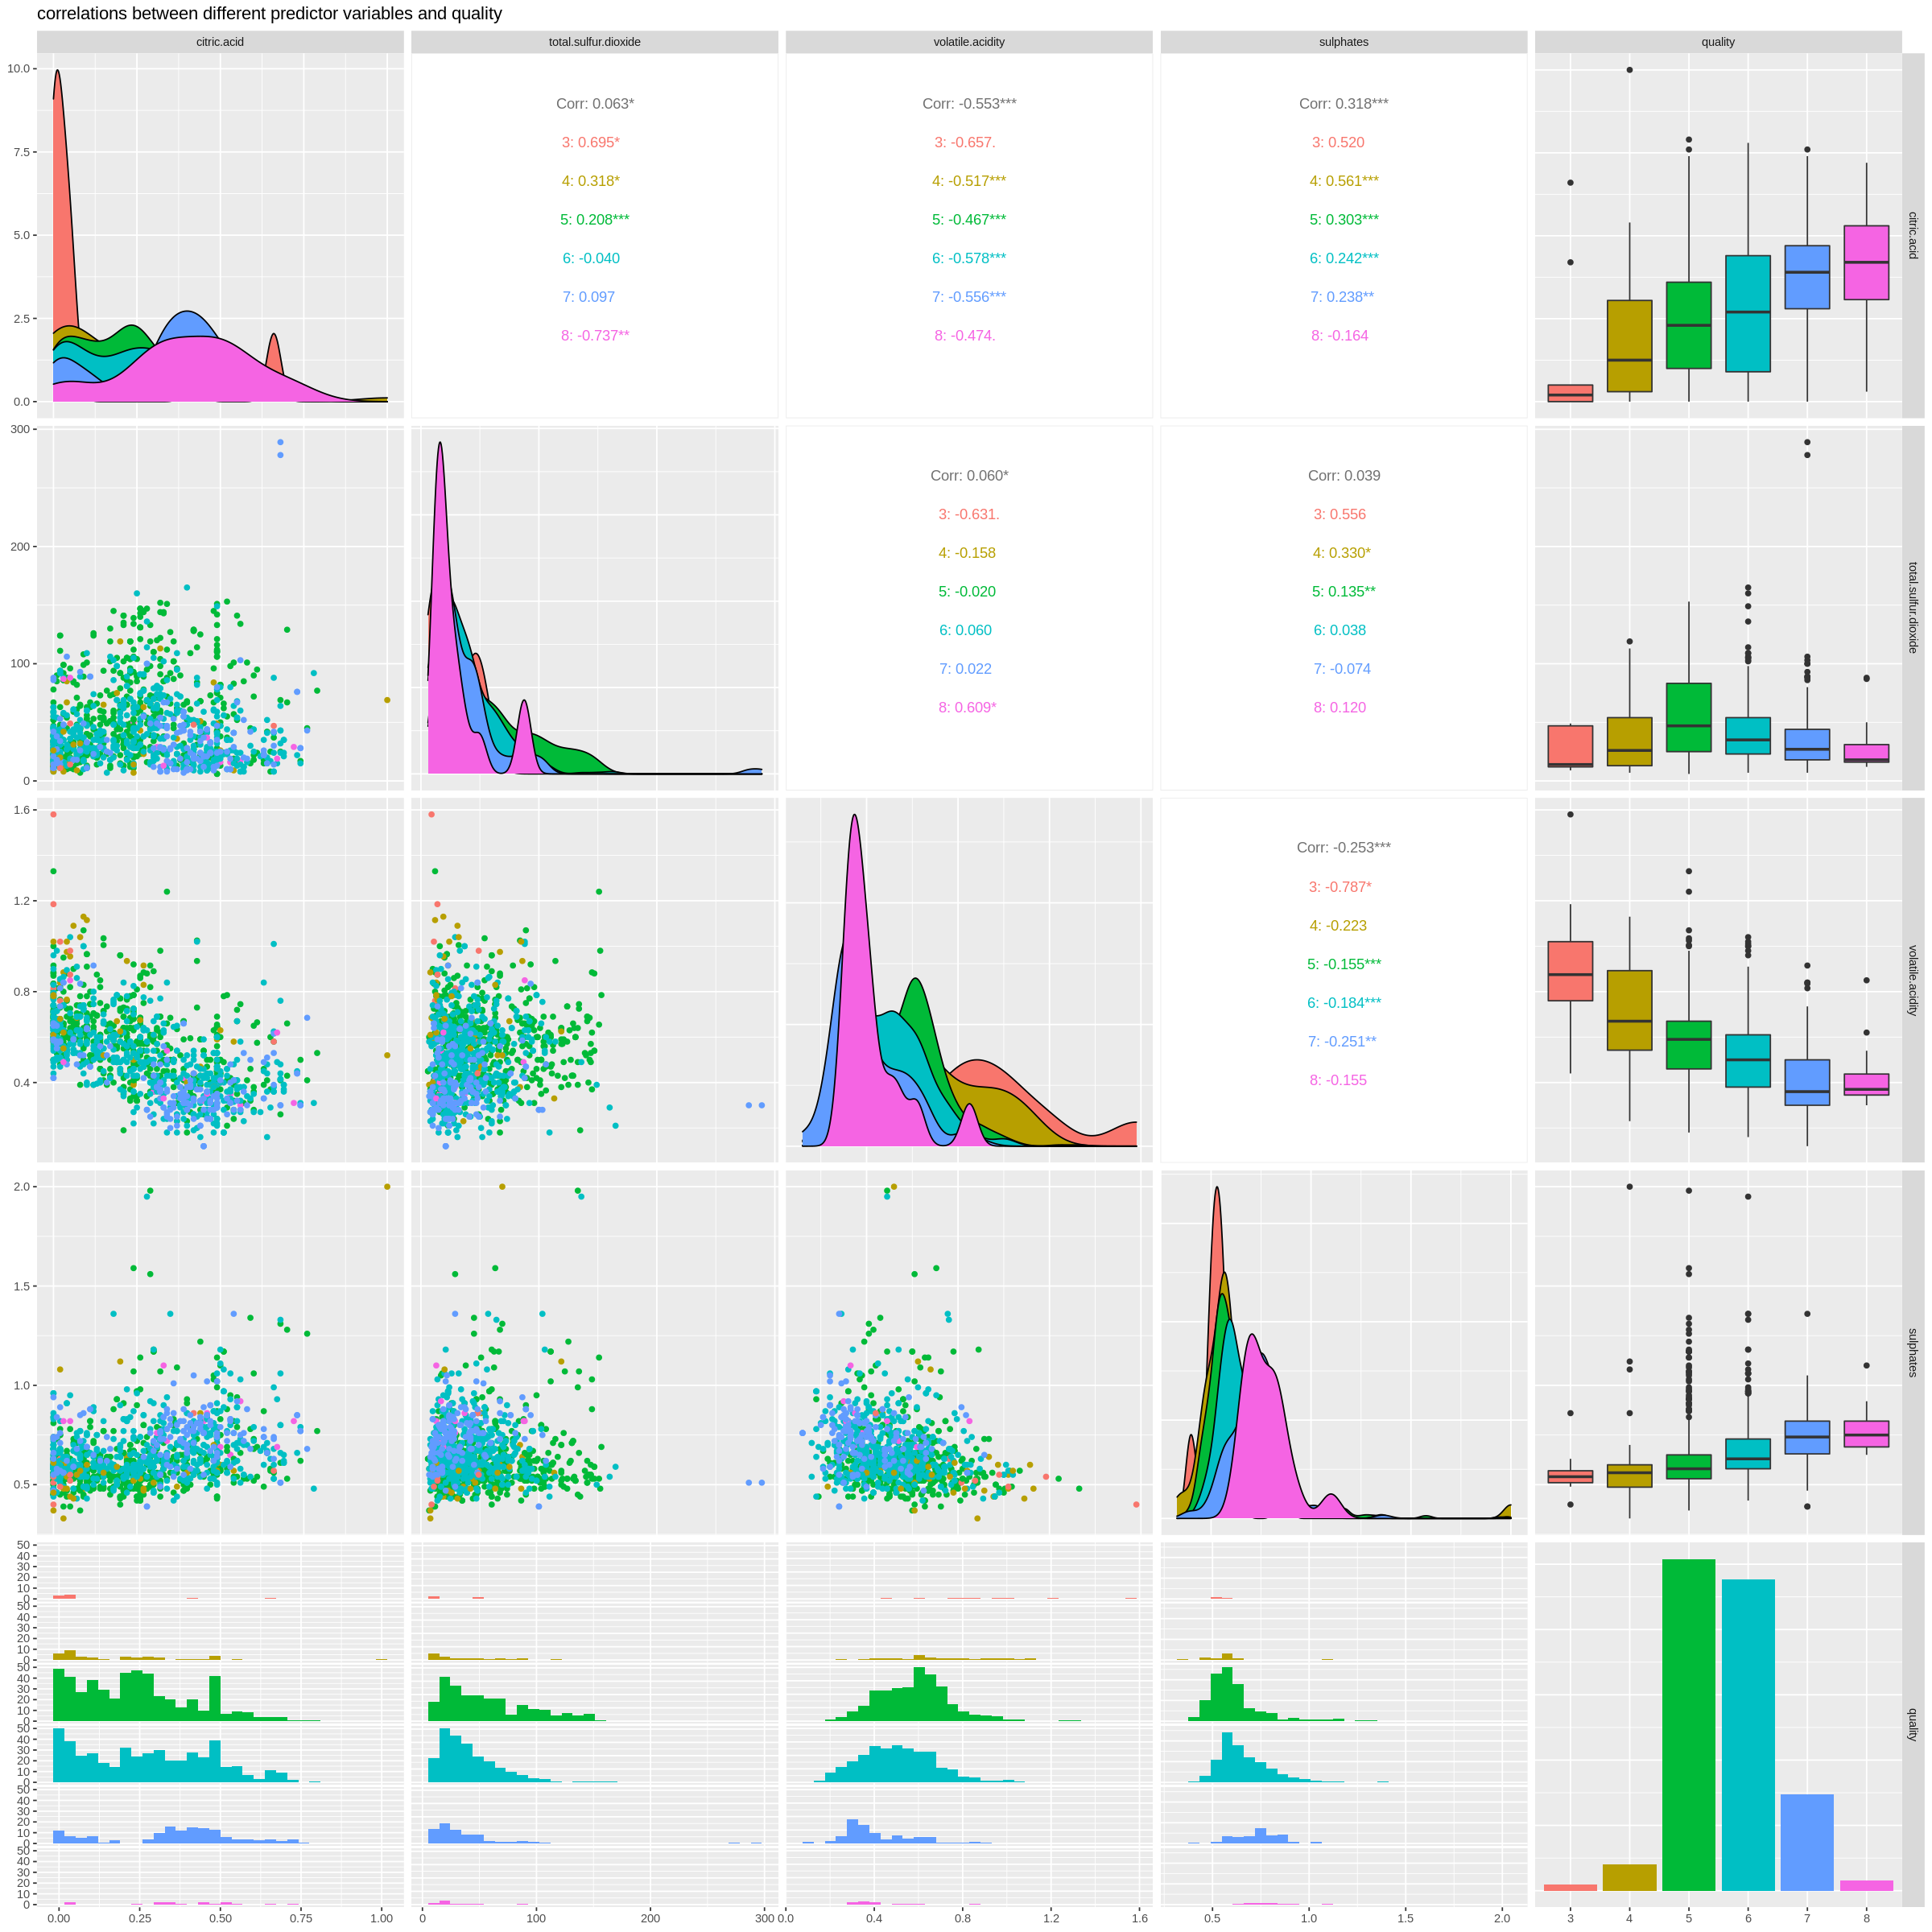

In [293]:
options(repr.plot.height = 20, repr.plot.width = 20)


ggpairs(wine_train,
        mapping = ggplot2::aes(colour = quality), 
        title = "correlations between different predictor variables and quality")

From the above plot, we can see that **Citric Acid, Total Sulfur Dioxide, Volatile Acidity** and **Sulphates** are strong predictors of wine quality. Thus, we shall select them as predictor variables for our model.

In [294]:
wine_train <- wine_train |>
                select(citric.acid, total.sulfur.dioxide, volatile.acidity, sulphates, quality) 

wine_test <- wine_test |>
                select(citric.acid, total.sulfur.dioxide, volatile.acidity, sulphates, quality) 


wine_train

citric.acid,total.sulfur.dioxide,volatile.acidity,sulphates,quality
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,67,0.88,0.68,5
0.04,54,0.76,0.65,5
⋮,⋮,⋮,⋮,⋮
0.17,24,0.56,0.68,7
0.44,34,0.32,0.80,7


### 3. Histogram of the quality variable

Plotting a histogram of the quality variable to see the relative distribution of the quality variable. This will give us a distribution of the concentration of numbers on the 1-10 quality scale.

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


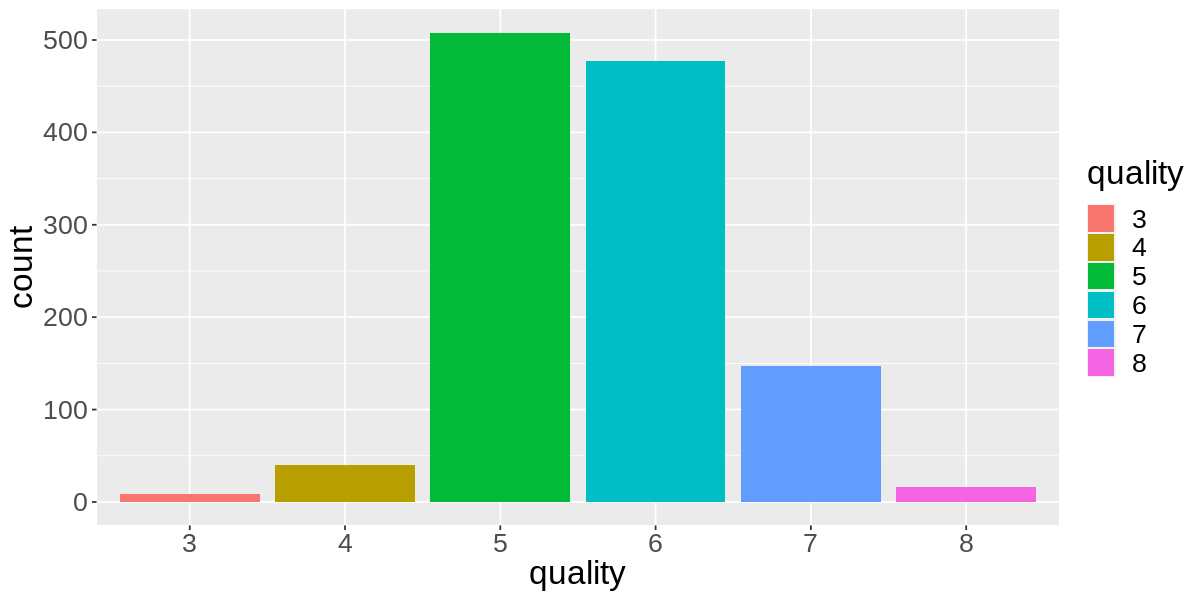

In [295]:
options(repr.plot.height = 5, repr.plot.width = 10)

quality_hist <- ggplot(wine_train, aes(x = quality, fill = quality)) +
                geom_histogram(stat = "count") +
                theme(text = element_text(size = 20))

quality_hist

The above graph tells us that **5 and 6 are the most commonly attributed quality** numbers for our dataset of wines. On the other hand, a quality of less than 4 and greater than 7 are extremely rare

### 3. Finding mean values and ranges for our variables

Summarizing the means and ranges of all variables using `summarize()` and `map_df()`.

In [280]:
# mean_summary <- summarize(wine_train, across(fixed.acidity:sulphates, mean))
mean_summary <- wine_train |>
                select(-quality) |>
                map_df(mean)

range_summary <- summarize(wine_train, across(-quality, range))

mean_summary
range_summary

citric.acid,total.sulfur.dioxide,volatile.acidity,sulphates
<dbl>,<dbl>,<dbl>,<dbl>
0.2702423,46.65079,0.5326525,0.655731


citric.acid,total.sulfur.dioxide,volatile.acidity,sulphates
<dbl>,<dbl>,<dbl>,<dbl>
0,6,0.12,0.33
1,289,1.58,2.00


The range data gives us the minimum and maximum values for each column in the database.

We can see from this table that the ranges for different variables vary hugely. This means we would have to **standardize the data** before we start building the model.

### Mean values corresponding to quality classes

Finding out means of predictors that correspond to each level in the quality scale.

In [281]:
group_by(wine_train, quality) |>
        summarize(across(everything(), mean))

quality,citric.acid,total.sulfur.dioxide,volatile.acidity,sulphates
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
3,0.1355556,25.88889,0.915000,0.5633333
4,0.2017500,38.07500,0.701375,0.6102500
⋮,⋮,⋮,⋮,⋮
7,0.3555102,36.93197,0.4067007,0.735034
8,0.4006250,30.18750,0.4243750,0.778125


From this table, we can see that a quality 4 wine for example corresponds to an average value of **99.7** in **Alcohol**.

This information can help us assess how well the model is functioning later.

## Visualization

We can use the `ggplot` function to graph how each variable contributes to each quality. Then can use the `plot_grid` function to group each graph together to help us better visualize and compare our data set. 

Additionally, we can also plot a color coded ggpair graph to assess how each variable corresponds with each other. 

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


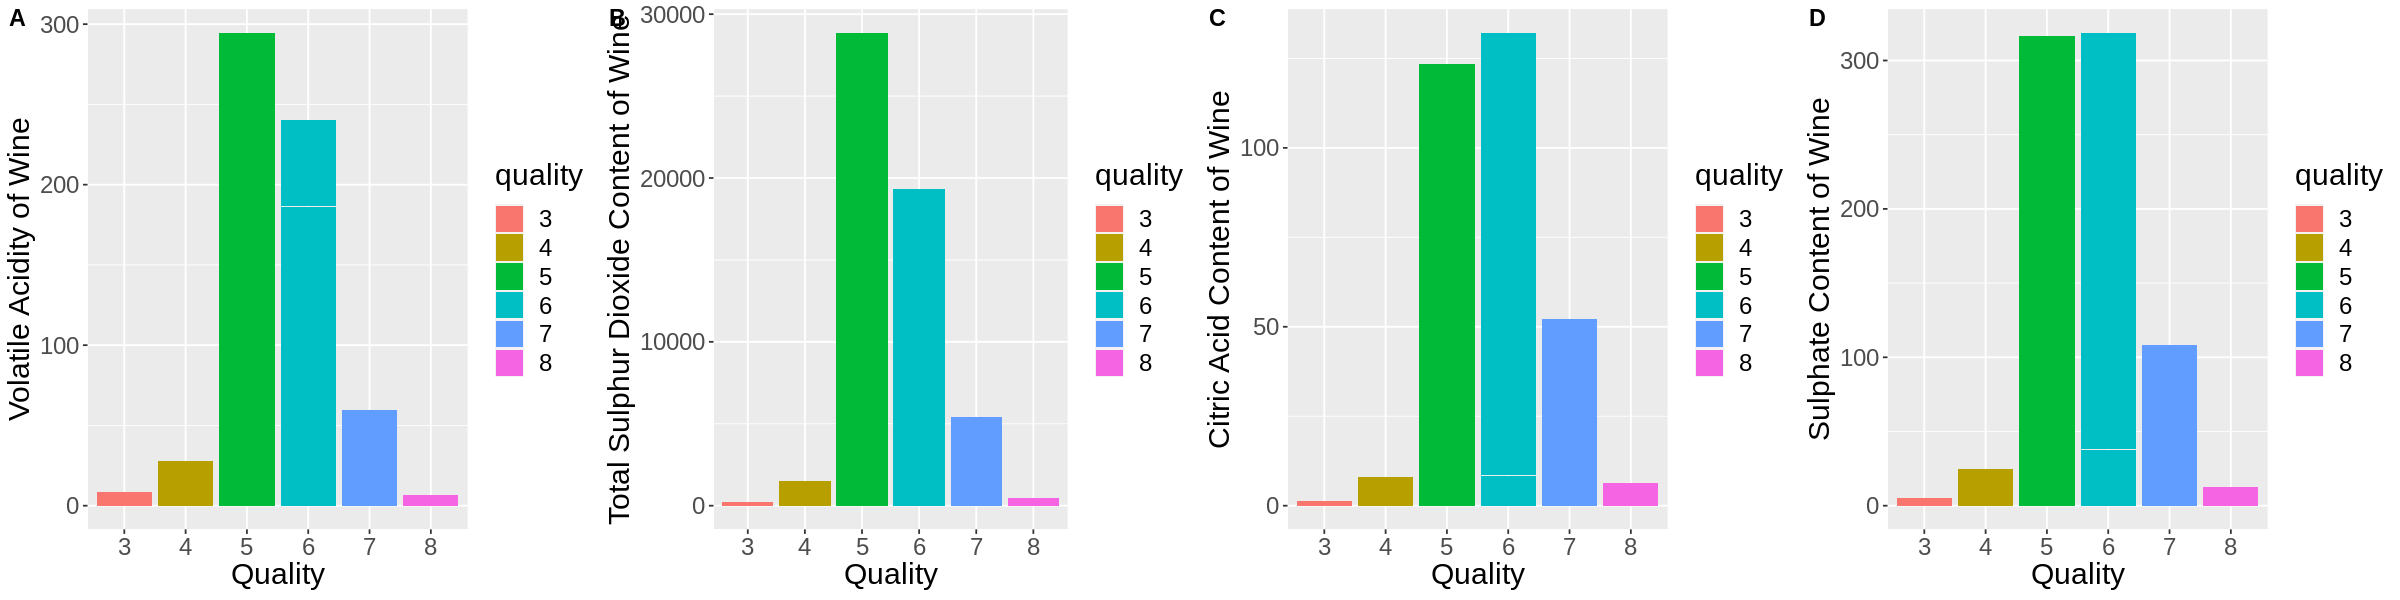

In [282]:
options(repr.plot.height = 5, repr.plot.width = 20)

volatile_acidity_plot <- ggplot(wine_train, aes(x = volatile.acidity, y = quality, fill = quality)) +
                geom_histogram(stat = "identity") +
                labs(x = "Volatile Acidity of Wine", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

total_sulfur_plot <- ggplot(wine_train, aes(x = total.sulfur.dioxide, y = quality, fill = quality)) +
                geom_histogram(stat = "identity") +
                labs(x = "Total Sulphur Dioxide Content of Wine", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

citric_acid_plot <- ggplot(wine_train, aes(x = citric.acid, y = quality, fill = quality)) +
                geom_histogram(stat = "identity") +
                labs(x = "Citric Acid Content of Wine", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

sulphates <- ggplot(wine_train, aes(x = sulphates, y = quality, fill = quality)) +
                geom_histogram(stat = "identity") +
                labs(x = "Sulphate Content of Wine", y = "Quality") +
                theme(text = element_text(size = 18)) +
                coord_flip()

plot_grid(volatile_acidity_plot, total_sulfur_plot, citric_acid_plot, sulphates,
          labels = c("A", "B", "C", "D"),
          ncol = 4, nrow = 1)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



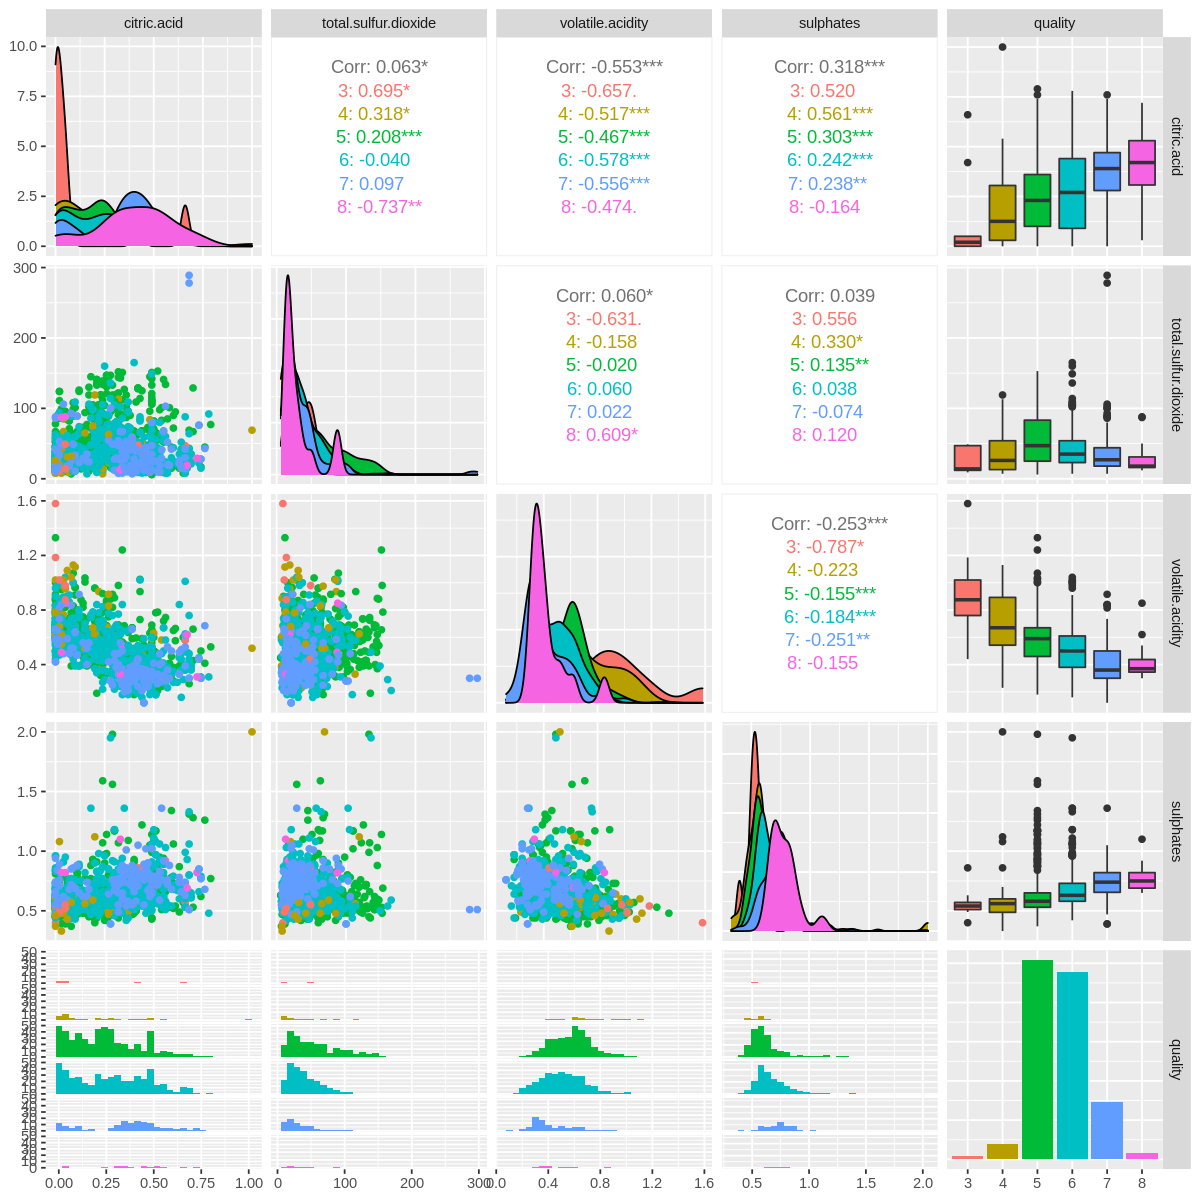

In [283]:
options(repr.plot.height = 10, repr.plot.width = 10)

ggpairs(wine_train,
        mapping = ggplot2::aes(colour = quality))

From reading these graphs, we can collect a lot of information regarding how each variable changes the quality of wine as well as see the correlation between each variable pairs.

## Method
We imported, cleaned up,  wrangled and split our data into training and testing datasets. Then we used a variety of graphs to determine which variables affect the quality of wine most. We then selected only the variables that are needed for our model. We shall now use these predictor variables and build a knn classification model using the tidymodels library to predict the quality of wines. To build the model, we would perform 5-fold cross validation to optimize our value of k. Finally, we can use the test dataset to assess the true accuracy of our built model.

We chose to use the knn classification model because the quality of wine is a set number of classes ranging from 1 to 10. This quality is a function of the various other columns we see in the dataset. Knn classification is an easily interpretable learning model and is thus ideal in our case.


## Expected Outcomes and Significance
1. **What do we expect to find?**

We expect to determine the ideal ratio of wine factors to achieve the highest quality of vinho verde, and which variables are more consequential in comparison to others. There may be a “breaking point” within a variable, (a spot where the quality will drastically change after a certain threshold). 

2. **What impact could such findings have?**

Determining wine quality can promote wine testing and ensure safety within the food industry. It can inform consumers and motivate sellers to uphold a certain standard of quality. Furthermore, the quality of wine can serve as a reflection of its contents, which provides insight as to whether the wine is safe and follows food health and safety guidelines. 

3. **What future questions could this lead to?**

There may be further research into the factors not in this dataset, and whether certain variables can be compromised. It can also lead to further questions like “How do we cost effectively make high quality wine”, or wine producing the most sales, etc. 


## The K-Nearest-Neighbors Classification Model

### 1. Splitting the dataset

We split the data using the `initial_split()` function shown above. 

### 2. Cross validation

In cross validation, we split the data into k folds. We then train the model on k-1 folds and use the remaining fold to evaluate the performance of the model. This process is repeated k times, with a different fold used for evaluation each time. The final performance measure is the average performance across all k iterations.

This helps optimize the model with the best number of neighbours.

Here, we used the `vfold_cv()` function to split up the training data for cross validation. 

In [284]:
set.seed(10)

wine_vfold <- vfold_cv(wine_train, v = 10, strata = quality)

### 3. Creating a recipe and centering + scaling the data

We passed in the training data set into the `recipe()` function to create a recipe that specifies the target variable `quality`, which is the one that we want to predict while all the rest are used as predictors.

The `step_center()` and `step_scale()` are both used to standardize, which will centre and scale all the variables in the dataset. We center and scale the variables because all variables have different scales and this will ensure that scale doesn't negatively skew our model in one direction. The centered and scaled variables then have a mean of 0 and standard deviation of 1.

In [285]:
wine_recipe <- recipe(quality ~ . , data = wine_train) |>
               step_scale(all_predictors()) |>
               step_center(all_predictors())

wine_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

### 4. Creating the model

We created a K-Nearest-Neighbors model specification using the `nearest_neighbor()` function with the `tune()` function since we want to select the best value of K for this model. 

The `set_engine()` specifies which package or system will be used for training the model, which in this case, we use the “kknn” package to perform the K-nearest neighbours classification. 

The `set_mode` function specifies what type of problem we are dealing with, which in this case, this is a classification problem. 

In [296]:
set.seed(15)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


### 5. Creating a workflow and obtaining results for our cross validation

We added the `recipe` and `model specification` to a `workflow()`, and used the `tune_grid()` function on the train/validation splits to estimate the classifer accuracy for a range of K values. 

In [297]:
set.seed(20)

knn_results <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples  = wine_vfold, grid = 10) |>
    collect_metrics() |> 
    filter(.metric == "accuracy")

knn_results

! Fold01: internal:
  No observations were detected in `truth` for level(s): '3'
  Computation will proceed by ignoring those levels.

! Fold02: internal:
  No observations were detected in `truth` for level(s): '8'
  Computation will proceed by ignoring those levels.

! Fold04: internal:
  No observations were detected in `truth` for level(s): '3', '8'
  Computation will proceed by ignoring those levels.

! Fold06: internal:
  No observations were detected in `truth` for level(s): '3'
  Computation will proceed by ignoring those levels.

! Fold09: internal:
  No observations were detected in `truth` for level(s): '3'
  Computation will proceed by ignoring those levels.



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.5639181,10,0.006294854,Preprocessor1_Model1
4,accuracy,multiclass,0.5368992,10,0.014308886,Preprocessor1_Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,accuracy,multiclass,0.5338542,10,0.011505543,Preprocessor1_Model8
14,accuracy,multiclass,0.5379997,10,0.008547508,Preprocessor1_Model9


### 6. Plotting accuracy values to determine best k

We created an "accuracy_vs_k_plot" in order to help us choose the optimal k value. 

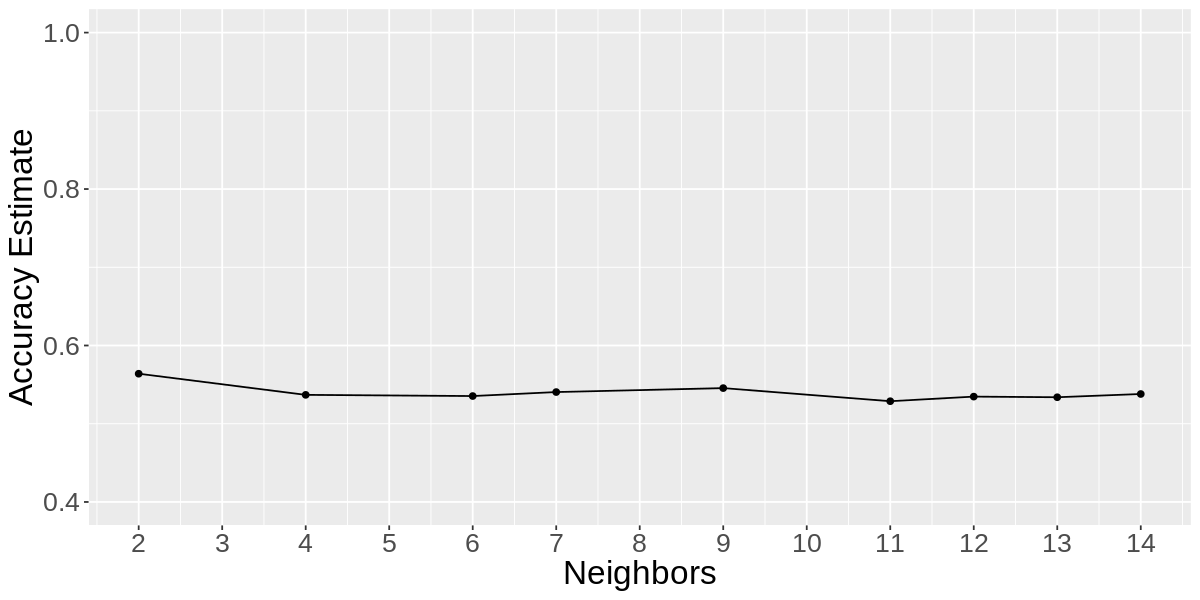

In [298]:
accuracy_vs_k_plot <- ggplot(knn_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) +
    scale_y_continuous(limits = c(0.4, 1.0))
    

accuracy_vs_k_plot

### 7. Choosing best k

The ideal value of k must be:
1. An odd number (to eliminate the possibility of a tie in knn votes)
2. The value with a high accuracy in cross validation
3. No drastic changes in accuracy to the left or right of our value in the k-vs-accuracy graph.

Based on the plot above, we choose K = 3 because it is the odd number with the best value of accuracy using our model. We can now make a new model specifcation using k = 3, and re-train the classifier using the `fit()` function. 

In [289]:
best_k_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
                set_engine("kknn") |>
                set_mode("classification")

best_k_spec

best_fit <- workflow() |>
            add_recipe(wine_recipe) |> 
            add_model(best_k_spec) |> 
            fit(data = wine_train)

best_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 3
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4853801
Best kernel: rectangular
Best k: 3

### 8. Calculating accuracy of our model

We used the predictions made by our model and compared the accuracy of the predictions to the true values in the test set to get the accuracy. We can present these findings in a tabular confusion matrix.

In [299]:
wine_test_predictions <- predict(best_fit, wine_test) |>
                            bind_cols(wine_test)

wine_test_predictions_accuracy <- wine_test_predictions |> 
                                    metrics(truth = quality, estimate = .pred_class) |> 
                                    select(.metric, .estimate) |> 
                                    head(1)

wine_confusion_mat <- wine_test_predictions |> 
                        conf_mat(truth = quality, estimate = .pred_class)

wine_test_predictions

wine_test_predictions_accuracy

wine_confusion_mat

.pred_class,citric.acid,total.sulfur.dioxide,volatile.acidity,sulphates,quality
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5,0.00,34,0.70,0.56,5
5,0.19,148,0.62,0.93,5
⋮,⋮,⋮,⋮,⋮,⋮
6,0.10,51,0.55,0.76,6
6,0.47,42,0.31,0.66,6


.metric,.estimate
<chr>,<dbl>
accuracy,0.475


          Truth
Prediction  3  4  5  6  7  8
         3  0  0  0  1  0  0
         4  0  1  2  0  0  0
         5  1  5 98 57  7  0
         6  0  6 67 75 24  2
         7  0  1  4 27 16  0
         8  0  0  0  1  5  0

This shows that the model has an accuracy of 54%. This means that roughly 54% of the time, the model predicted the quality of wine correctly according to the testing dataset. 

There may be many reasons why our model has a relatively low accuracy. First and foremost, quality is a very subjective predictor. What may be considered good quality under some criteria, may be average quality under other criteria. Additionally, as we can see from the `ggpairs` plot, the dataset contains too many irrelvant and noisy features. This makes it difficult for the model to accurately determine the classes of new, unseen data. 

### Visualizing the results

We can visualise the model using the `workflow_plot` below.

[[We need to create one plot for the 2 best predictor variables and one plot for the 2 worst predictor variables. (Chosen using the ggpairs graph above)]]
[the code below is taking WAYYY too long to work]

In [ ]:
# create the grid of area/smoothness vals, and arrange in a data frame

tot_grid <- seq(min(wine_train $ total.sulfur.dioxide), 
                max(wine_train $ total.sulfur.dioxide), 
                length.out = 100)

vol_grid <- seq(min(wine_train $ volatile.acidity), 
                max(wine_train $ volatile.acidity), 
                length.out = 100)

cit_grid <- seq(min(wine_train $ citric.acid), 
                max(wine_train $ citric.acid), 
                length.out = 100)

sul_grid <- seq(min(wine_train $ sulphates), 
                max(wine_train $ sulphates), 
                length.out = 100)


asgrid <- as_tibble(expand.grid(total.sulfur.dioxide = tot_grid, 
                                volatile.acidity = vol_grid, 
                                citric.acid = cit_grid,
                                sulphates = sul_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(best_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(Class = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = wine_train, 
             mapping = aes(x = total.sulfur.dioxide, 
                           y = volatile.acidity, 
                           color = quality), 
             alpha = 0.75) +

  geom_point(data = prediction_table, 
             mapping = aes(x = total.sulfur.dioxide, 
                           y = volatile.acidity, 
                           color = quality), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Quality", 
       x = "Area (standardized)", 
       y = "Smoothness (standardized)") +
  theme(text = element_text(size = 12))

wkflw_plot

## Discussion

1. **Summarize what you found**

We found that with most wines, for the variables we tested, the quantity of any of our chosen variables seems to peak around quality ~5. After quality level 5 we actually see a decrease in most of the wines. This means that after quality level 5, the wine begins to rely less and less on our tested variables and more on other factors outside of those our data tested for.


2. **Discuss whether this is what you expected to find** 

This is not what we expected to find. We believed that the trend would be more or less consistent throughout the entire span of the variable with certain things getting lower and lower and others higher and higher the more that quality changed. If not that then we expected that the wine would get closer to some kind of "sweet spot" and that all variables would be ever approaching a single number albeit different numbers for each variable. This however was not what we saw within the data. Instead, there was a near universal point in which all variables began to decrease and continued to do so until the quality maximum was reached.


3. **Discuss what impact could such findings have?**

Portugal makes roughly 783.9 million euros worth of wine a year, producing no small amount of this much loved drink. With such a large industry, and their reputation of Vinho Verde, information like this can be groundbreaking. Wineries around the world can take this information and use it in order to adjust their wine making process in order to improve the quality of their wine. Furthermore, with such an oversaturated market one of the best ways that a business could stand out would be to ensure that they hold themselves to the highest quality standards. This is also of great benefit to the consumer so that they know which wine bottles are the best to buy.


4. **Discuss what future questions could this lead to?**

There may be further research into the factors not in this dataset, and whether certain variables can be compromised. The relationship between certain variables would definitely be something that manufacturers would have to take into consideration in order to maximize the quality of the wine. It would also lead to more economic based questions such as "What is the most cost effective way to make the highest quality wine?" and "What are the most important variables to control?" These questions in such a large industry can have an extreme impact and forever change the way in which Vinho Verde is produced.

## References

1. Barret Schloerke, Di Cook, Joseph Larmarange, Francois Briatte,
  Moritz Marbach, Edwin Thoen, Amos Elberg and Jason Crowley (2021).
  GGally: Extension to 'ggplot2'. R package version 2.1.2.
  https://CRAN.R-project.org/package=GGally

1. Cortez, P., Cerdeira, A., Almeida, F., Matos, T., &amp; Reis, J. (2009). Modeling wine preferences by data mining from physicochemical properties. Decision Support Systems, 47(4), 547–553. https://doi.org/10.1016/j.dss.2009.05.016 

2. R Core Team (2022). R: A language and environment for statistical
  computing. R Foundation for Statistical Computing, Vienna, Austria.
  URL https://www.R-project.org/.

3.   Wickham et al., (2019). Welcome to the tidyverse. Journal of Open
  Source Software, 4(43), 1686, https://doi.org/10.21105/joss.01686

4.   Dirk Eddelbuettel with contributions by Antoine Lucas, Jarek
  Tuszynski, Henrik Bengtsson, Simon Urbanek, Mario Frasca, Bryan
  Lewis, Murray Stokely, Hannes Muehleisen, Duncan Murdoch, Jim Hester,
  Wush Wu, Qiang Kou, Thierry Onkelinx, Michel Lang, Viliam Simko, Kurt
  Hornik, Radford Neal, Kendon Bell, Matthew de Queljoe, Ion Suruceanu,
  Bill Denney, Dirk Schumacher and and Winston Chang. (2021). digest:
  Create Compact Hash Digests of R Objects. R package version 0.6.29.
  https://CRAN.R-project.org/package=digest

5.   Philipp Angerer, Thomas Kluyver and Jan Schulz (2022). repr:
  Serializable Representations. R package version 1.1.4.
  https://CRAN.R-project.org/package=repr

6.   Kuhn et al., (2020). Tidymodels: a collection of packages for
  modeling and machine learning using tidyverse principles.
  https://www.tidymodels.org

7.   Claus O. Wilke (2020). cowplot: Streamlined Plot Theme and Plot
  Annotations for 'ggplot2'. R package version 1.1.1.
  https://CRAN.R-project.org/package=cowplot